In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import traceback

Found 188 CSV files


Loading datasets:   5%|███▍                                                            | 10/188 [00:00<00:01, 91.15it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv


Loading datasets:  17%|██████████▋                                                    | 32/188 [00:00<00:01, 103.60it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv


Loading datasets:  54%|██████████████████████████████████▏                            | 102/188 [00:01<00:00, 88.74it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv


Loading datasets:  93%|██████████████████████████████████████████████████████████▋    | 175/188 [00:02<00:00, 72.59it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv


Loading datasets: 100%|███████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 86.85it/s]


detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-55-39_1.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-55-39_2.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-55-39_7.csv
Found 75 CSV files


Loading datasets:  48%|███████████████████████████████▏                                 | 36/75 [00:00<00:00, 85.87it/s]

detected high steering, skip this set: data_synced_chunk2/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv


Loading datasets:  84%|██████████████████████████████████████████████████████▌          | 63/75 [00:00<00:00, 84.19it/s]

detected high steering, skip this set: data_synced_chunk2/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv


Loading datasets: 100%|█████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 84.88it/s]



Dataset sizes:
Total samples: 211022
Train: 168817 (80.0%)
Validation: 42205 (20.0%)
Test: 87371 (100.0%)

Visualizing sample datapoints from training set...


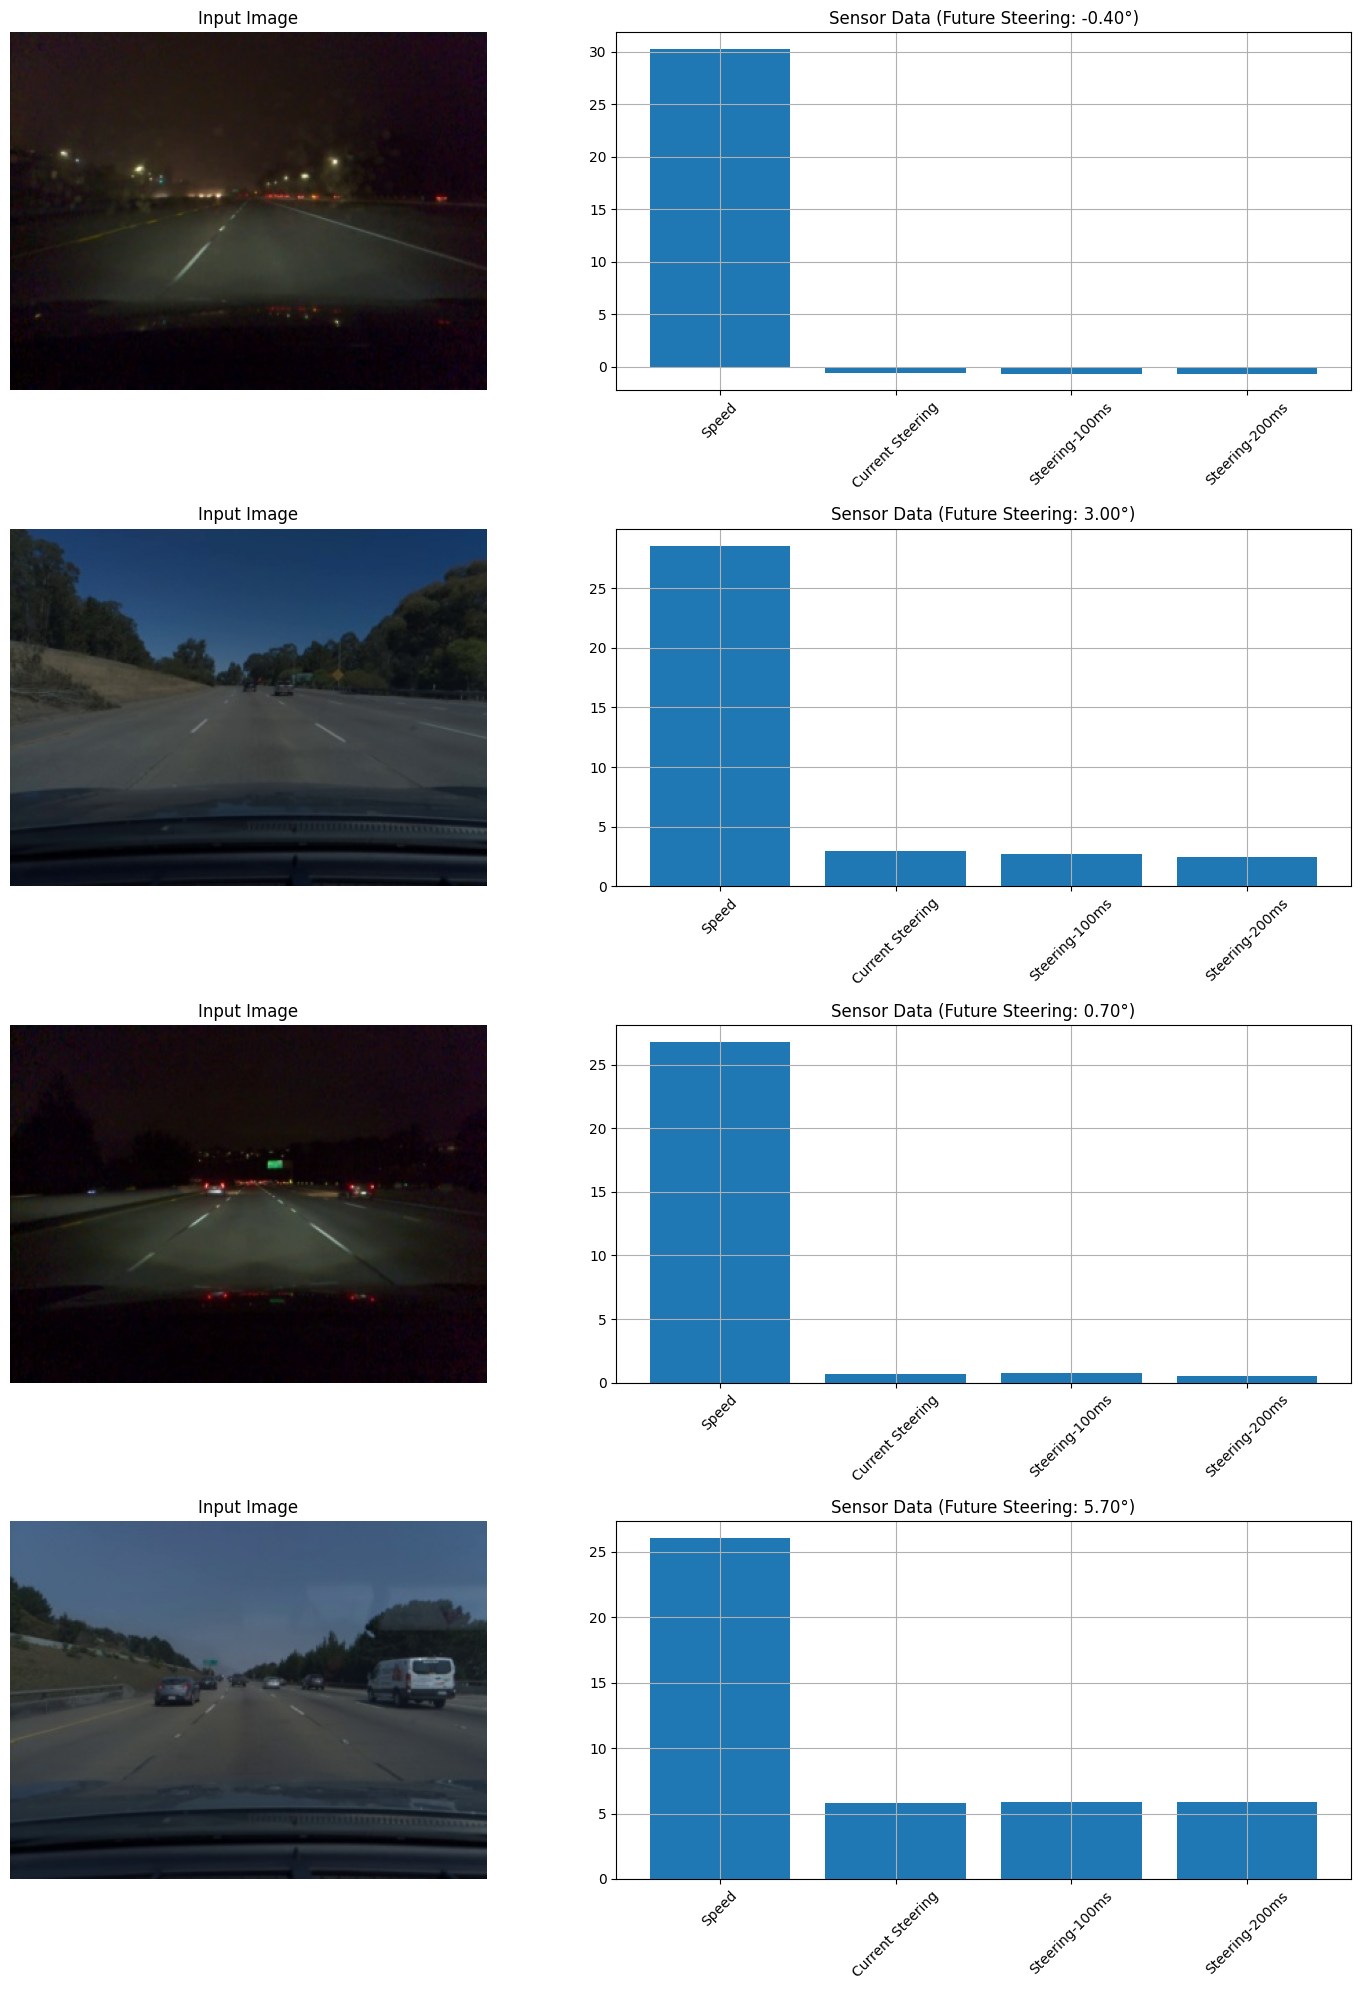

In [3]:

class DrivingDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None):  # Add data_dir as parameter
        # Load the CSV data
        self.data = pd.read_csv(csv_file)
        # Get frames directory path from CSV filename
        filename = os.path.basename(csv_file)
        self.frames_dir = os.path.join(data_dir, f"{filename[:-4]}_frames")
        
        #print(f"CSV file: {csv_file}")
        #print(f"Frames directory: {self.frames_dir}")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get frame index from data
        frame_idx = int(self.data.iloc[idx]['frame_idx'])
        
        # Load frame image
        frame_path = os.path.join(self.frames_dir, f"{frame_idx}.jpg")
        frame = Image.open(frame_path).convert('RGB')
        
        if self.transform:
            frame = self.transform(frame)
        
        row = self.data.iloc[idx]
        
        # Get current sensor data (inputs)
        speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
        
        current_data = torch.tensor([
            speed_value,
            #row['gyro_x'], row['gyro_y'], row['gyro_z'],
            row['current_steering'],
            row['steering_angle_prev_100ms'],
            row['steering_angle_prev_200ms']
        ], dtype=torch.float32)
        
        # Get future steering angle (target)
        target = torch.tensor(row['future_steering'], dtype=torch.float32)
        
        return frame, current_data, target

def visualize_sample_datapoints(dataset, num_samples=4):
    """
    Visualize a few sample datapoints from the dataset to verify format
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(len(dataset))
        image, sensor_data, target = dataset[idx]
        
        # Convert image tensor back to displayable format
        img = image.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Create sensor data visualization with updated labels
        sensor_labels = [
            'Speed', 
            #'Gyro X', 'Gyro Y', 'Gyro Z',
            'Current Steering',
            'Steering-100ms',  # Add label for 100ms history
            'Steering-200ms',  # Add label for 200ms history
        ]
        
        # Plot sensor data as a bar chart
        axes[i, 1].bar(sensor_labels, sensor_data.numpy())
        axes[i, 1].set_title(f'Sensor Data (Future Steering: {target:.2f}°)')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# -- training --
# Get list of all CSV files in data_synced
train_val_csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(train_val_csv_files)} CSV files")

# Create datasets for each segment
training_data_dir = 'data_synced'
train_val_datasets = []
#counter = 0
for csv_file in tqdm(train_val_csv_files, desc="Loading datasets"):
    try:
        #if counter > 10:
            #break
        data_for_large_steer_angle_check = pd.read_csv(csv_file)
        if (((data_for_large_steer_angle_check['future_steering'] > 45).any()) | ((data_for_large_steer_angle_check['future_steering'] < -45).any())):
            print("detected high steering, skip this set:", csv_file)
            continue
        dataset = DrivingDataset(csv_file, training_data_dir)
        train_val_datasets.append(dataset)
        #print(f"Successfully loaded dataset from {csv_file}")
        #counter = counter + 1
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not train_val_datasets:
    raise RuntimeError("No training datasets were successfully loaded!")

# -- testing --
# Get list of all CSV files in data_synced
testing_csv_files = glob.glob('data_synced_chunk2/*.csv')
print(f"Found {len(testing_csv_files)} CSV files")

# Create datasets for each segment
testing_data_dir = 'data_synced_chunk2'
testing_datasets = []
#counter = 0
for csv_file in tqdm(testing_csv_files, desc="Loading datasets"):
    try:
        #if counter > 10:
            #break
        data_for_large_steer_angle_check = pd.read_csv(csv_file)
        if (((data_for_large_steer_angle_check['future_steering'] > 45).any()) | ((data_for_large_steer_angle_check['future_steering'] < -45).any())):
            print("detected high steering, skip this set:", csv_file)
            continue
        dataset = DrivingDataset(csv_file, testing_data_dir)
        testing_datasets.append(dataset)
        #print(f"Successfully loaded dataset from {csv_file}")
        #counter = counter + 1
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not testing_datasets:
    raise RuntimeError("No testing datasets were successfully loaded!")

# Combine all datasets
full_train_val_dataset = ConcatDataset(train_val_datasets)
total_train_val_size = len(full_train_val_dataset)

# Split dataset into train, validation(80%, 20%)
total_train_val_len = len(full_train_val_dataset)
train_end = int(0.8 * total_train_val_len) # from 0 to 0.8
val_end = total_train_val_len # from 0.8 to 1

full_testing_dataset = ConcatDataset(testing_datasets)
total_testing_size = len(full_testing_dataset)
total_testing_len = len(full_testing_dataset)

train_dataset = Subset(full_train_val_dataset, list(range(0, train_end))) # from 0 to 8
val_dataset = Subset(full_train_val_dataset, list(range(train_end, val_end))) # from 0.8 to 1
test_dataset = Subset(full_testing_dataset, list(range(0, total_testing_len))) # full testing dataset

print(f"\nDataset sizes:")
print(f"Total samples: {total_train_val_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_train_val_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_train_val_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_testing_size*100:.1f}%)")

# Create data loaders with no workers for simplicity
train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=512,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

# Visualize some samples to verify data format
print("\nVisualizing sample datapoints from training set...")
visualize_sample_datapoints(train_dataset)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class SteeringAngleCNN(nn.Module):
    """
    CNN model for predicting future steering angles (t+200ms) from current dashcam images and sensor data.
    Based on NVIDIA's PilotNet architecture with additional sensor inputs.
    """
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()

        # Number of sensor inputs (all current data)
        # speed (1), gyro(removed for now), current_steering(1) = 2, history_steering=2
        self.sensor_input_size = 4

        # Convolutional layers for image processing
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(36),

            nn.Dropout(0.15),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(0.15),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(0.15),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        # Sensor processing layers
        self.sensor_layers = nn.Sequential(
            nn.Linear(self.sensor_input_size, 8),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            #nn.Dropout(0.2)
        )

        # Placeholder for combined layers (will update in _calculate_conv_output_size)
        self.combined_layers = nn.Sequential(
            nn.Linear(1, 128),  # Placeholder
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # Predicting future steering angle
        )

        # Calculate the correct input size for combined layers
        self._calculate_conv_output_size()

    def _calculate_conv_output_size(self):
        """Calculate the size of the flattened features after convolution layers"""
        x = torch.zeros(1, 3, 260, 346)
        x = self.conv_layers(x)
        conv_flat_size = x.numel() // x.size(0)

        # Update the first linear layer in combined_layers
        combined_input_size = conv_flat_size + 8  # 4 is from sensor_layers output
        self.combined_layers[0] = nn.Linear(combined_input_size, 128)

        print(f"Calculated convolutional output size: {x.size()}")
        print(f"Flattened conv features size: {conv_flat_size}")
        print(f"Combined input size: {combined_input_size}")

    def forward(self, image, sensor_data):
        """
        Forward pass through the network.
        image: Tensor of shape (B, 3, H, W)
        sensor_data: Tensor of shape (B, sensor_input_size)
        Returns: Predicted steering angle at t+200ms
        """
        # Process image through CNN
        x_img = self.conv_layers(image)
        x_img = x_img.view(x_img.size(0), -1)  # Flatten CNN features

        # Process sensor data
        x_sensor = self.sensor_layers(sensor_data)

        # Combine image and sensor features
        x_combined = torch.cat([x_img, x_sensor], dim=1)
        
        # Predict future steering angle
        future_steering = self.combined_layers(x_combined)
        return future_steering

In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping, proper cleanup, and error handling.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    scaler = torch.amp.GradScaler(device='cuda')
    
    # GPU Information printing
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")
    
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    accumulation_steps = 2

    try:
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            running_loss = 0.0
            optimizer.zero_grad(set_to_none=True)
            
            try:
                with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
                    for i, data in enumerate(pbar):
                        try:
                            images, sensor_data, targets = data
                            
                            # Asynchronous data transfer with error handling
                            try:
                                images = images.to(device, non_blocking=True)
                                sensor_data = sensor_data.to(device, non_blocking=True)
                                targets = targets.to(device, non_blocking=True).view(-1, 1)
                            except RuntimeError as e:
                                print(f"CUDA transfer error: {str(e)}")
                                continue

                            # Mixed precision training
                            with torch.amp.autocast(device_type='cuda'):
                                outputs = model(images, sensor_data)
                                loss = criterion(outputs, targets) / accumulation_steps

                            # Scale loss and backward pass
                            scaler.scale(loss).backward()
                            
                            # Update weights every accumulation_steps
                            if (i + 1) % accumulation_steps == 0:
                                scaler.step(optimizer)
                                scaler.update()
                                optimizer.zero_grad(set_to_none=True)

                            running_loss += loss.item() * images.size(0) * accumulation_steps
                            pbar.set_postfix({
                                'loss': f'{loss.item():.3f}',
                                'gpu_mem_allocated': f"{torch.cuda.memory_allocated(0)/1e9:.1f}GB",
                                'gpu_mem_reserved': f"{torch.cuda.memory_reserved(0)/1e9:.1f}GB"
                            })
                            
                        except Exception as e:
                            print(f"Error in training batch: {str(e)}")
                            continue

            except Exception as e:
                print(f"Error in training epoch: {str(e)}")
                continue

            # Calculate epoch losses
            epoch_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation phase
            model.eval()
            running_loss = 0.0

            try:
                with torch.no_grad():
                    for data in val_loader:
                        try:
                            images, sensor_data, targets = data
                            images = images.to(device, non_blocking=True)
                            sensor_data = sensor_data.to(device, non_blocking=True)
                            targets = targets.to(device, non_blocking=True).view(-1, 1)

                            with torch.amp.autocast(device_type='cuda'):
                                outputs = model(images, sensor_data)
                                loss = criterion(outputs, targets)
                            running_loss += loss.item() * images.size(0)
                            
                        except Exception as e:
                            print(f"Error in validation batch: {str(e)}")
                            continue

            except Exception as e:
                print(f"Error in validation phase: {str(e)}")
                # If validation fails, use training loss instead
                epoch_val_loss = epoch_train_loss
            else:
                epoch_val_loss = running_loss / len(val_loader.dataset)
            
            val_losses.append(epoch_val_loss)

            print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

            # Early stopping check
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"Unexpected error during training: {str(e)}")
    finally:
        # Proper cleanup of workers
        if hasattr(train_loader, '_iterator') and train_loader._iterator is not None:
            try:
                train_loader._iterator._shutdown_workers()
            except:
                pass
        
        if hasattr(val_loader, '_iterator') and val_loader._iterator is not None:
            try:
                val_loader._iterator._shutdown_workers()
            except:
                pass

        # Load best model if we found one
        if best_model is not None:
            model.load_state_dict(best_model)
            print("Loaded best model from checkpoint")
        
        # Clear CUDA cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Plot training results if we have any
    if train_losses and val_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    return model, train_losses, val_losses

In [6]:
def test_model(model, test_loader, sample_rate=10):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = float(np.mean((all_preds - all_targets) ** 2))
    mae = float(np.mean(np.abs(all_preds - all_targets)))
    within_1_deg = float(np.mean(np.abs(all_preds - all_targets) < 1.0) * 100)
    within_3_deg = float(np.mean(np.abs(all_preds - all_targets) < 3.0) * 100)
    within_5_deg = float(np.mean(np.abs(all_preds - all_targets) < 5.0) * 100)

    # Create metrics dictionary
    metrics = {
        'mse': mse,
        'mae': mae,
        'within_1_deg': within_1_deg,
        'within_3_deg': within_3_deg,
        'within_5_deg': within_5_deg
    }

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Sample every 'sample_rate' points for visualization
    sampled_preds = all_preds[::sample_rate]
    sampled_targets = all_targets[::sample_rate]
    sampled_preds = all_preds[1000:1400]
    sampled_targets = all_targets[1000:1400]

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth (with sampled data points)
    plt.subplot(1, 2, 1)
    plt.plot(sampled_targets, label='Future Ground Truth', alpha=0.7)
    plt.plot(sampled_preds, label='Predicted Future', alpha=0.7)
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title(f'Predicted vs Actual Future Steering Angles (Sampled every {sample_rate} data points)')
    plt.legend()

    # Correlation plot (with sampled data points)
    plt.subplot(1, 2, 2)
    plt.scatter(sampled_targets, sampled_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title(f'Prediction Correlation (Sampled every {sample_rate} data points)')

    plt.tight_layout()
    plt.show()

    return metrics

In [7]:
def visualize_most_wrong_predictions(model, test_loader, num_worst=18, max_samples=1000):
    model.eval()
    device = next(model.parameters()).device
    
    # Use a heap to keep track of worst predictions
    import heapq
    worst_preds = []
    
    samples_processed = 0
    with torch.no_grad():
        for batch_idx, (images, sensor_data, targets) in enumerate(test_loader):
            batch_size = images.size(0)
            
            # Process in smaller chunks if needed
            for i in range(0, batch_size, 32):
                end = min(i + 32, batch_size)
                img_chunk = images[i:end].to(device)
                sensor_chunk = sensor_data[i:end].to(device)
                target_chunk = targets[i:end]
                
                preds = model(img_chunk, sensor_chunk)
                
                # Move to CPU
                preds = preds.cpu().numpy().squeeze()
                targs = target_chunk.numpy().squeeze()
                
                # Compute errors
                errors = np.abs(preds - targs)
                
                # Store worst predictions using a min heap
                for j in range(len(errors)):
                    error = errors[j]
                    # If we haven't collected enough samples yet or this error is worse than the smallest error in our collection
                    if len(worst_preds) < num_worst or error > worst_preds[0][0]:
                        # Store as (error, img, pred, target)
                        img_data = img_chunk[j].cpu().numpy()
                        if len(worst_preds) >= num_worst:
                            heapq.heappushpop(worst_preds, (error, img_data, preds[j], targs[j]))
                        else:
                            heapq.heappush(worst_preds, (error, img_data, preds[j], targs[j]))
            
            samples_processed += batch_size
            if samples_processed >= max_samples:
                break
    
    # Sort the worst predictions in descending order of error
    worst_preds.sort(reverse=True)
    
    # Plot those images
    fig, axes = plt.subplots(3, 6, figsize=(18, 10)) if num_worst == 18 else plt.subplots(3, 2, figsize=(12, 18))
    for (error, img, pred, target), ax in zip(worst_preds, axes.flat):
        img = img.transpose(1, 2, 0)
        
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f'Pred: {pred:.1f}° | Actual: {target:.1f}°\nError: {error:.1f}°')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Calculated convolutional output size: torch.Size([1, 64, 4, 7])
Flattened conv features size: 1792
Combined input size: 1800

Starting training...

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.8GB
Training on cuda:0


Epoch 1/15: 100%|████████| 330/330 [01:45<00:00,  3.12it/s, loss=0.453, gpu_mem_allocated=0.4GB, gpu_mem_reserved=1.5GB]


Epoch 1: Train Loss: 4.0395, Val Loss: 1.0654


Epoch 2/15: 100%|████████| 330/330 [01:33<00:00,  3.54it/s, loss=0.451, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 2: Train Loss: 1.1416, Val Loss: 0.9703


Epoch 3/15: 100%|████████| 330/330 [01:32<00:00,  3.56it/s, loss=0.374, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 3: Train Loss: 1.0293, Val Loss: 0.9678


Epoch 4/15: 100%|████████| 330/330 [01:33<00:00,  3.55it/s, loss=0.539, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 4: Train Loss: 0.9821, Val Loss: 0.9104


Epoch 5/15: 100%|████████| 330/330 [01:33<00:00,  3.54it/s, loss=0.402, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 5: Train Loss: 0.9729, Val Loss: 0.8668


Epoch 6/15: 100%|████████| 330/330 [01:32<00:00,  3.56it/s, loss=0.351, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 6: Train Loss: 0.9271, Val Loss: 0.8286


Epoch 7/15: 100%|████████| 330/330 [01:32<00:00,  3.56it/s, loss=0.654, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 7: Train Loss: 0.9137, Val Loss: 0.7947


Epoch 8/15: 100%|████████| 330/330 [01:32<00:00,  3.55it/s, loss=0.538, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 8: Train Loss: 0.8983, Val Loss: 1.2637


Epoch 9/15: 100%|████████| 330/330 [01:32<00:00,  3.56it/s, loss=0.619, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 9: Train Loss: 0.8821, Val Loss: 0.9227


Epoch 10/15: 100%|███████| 330/330 [01:33<00:00,  3.51it/s, loss=0.220, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 10: Train Loss: 0.8568, Val Loss: 0.7765


Epoch 11/15: 100%|███████| 330/330 [01:34<00:00,  3.50it/s, loss=0.274, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 11: Train Loss: 0.8454, Val Loss: 0.8561


Epoch 12/15: 100%|███████| 330/330 [01:34<00:00,  3.48it/s, loss=0.640, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 12: Train Loss: 0.8295, Val Loss: 0.7719


Epoch 13/15: 100%|███████| 330/330 [01:33<00:00,  3.51it/s, loss=0.337, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 13: Train Loss: 0.8268, Val Loss: 0.8017


Epoch 14/15: 100%|███████| 330/330 [01:33<00:00,  3.52it/s, loss=0.341, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 14: Train Loss: 0.8162, Val Loss: 0.9095


Epoch 15/15: 100%|███████| 330/330 [01:34<00:00,  3.49it/s, loss=0.318, gpu_mem_allocated=0.4GB, gpu_mem_reserved=5.7GB]


Epoch 15: Train Loss: 0.7952, Val Loss: 0.8345
Loaded best model from checkpoint


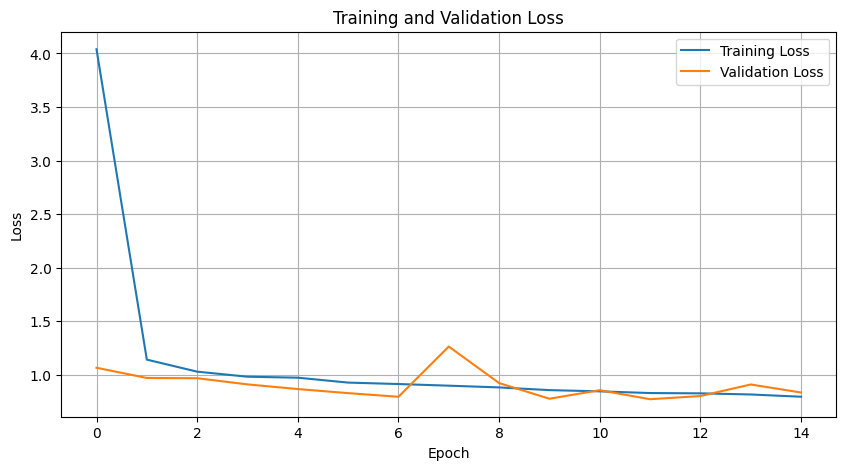


Model saved to 'v4_CNN2.pth'


In [8]:
# CUDA optimizations
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

# Initialize model and move to GPU
model = SteeringAngleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print("\nStarting training...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=15,
    patience=5
)

# Save the trained model
torch.save(model.state_dict(), 'v4_CNN2.pth')
print("\nModel saved to 'v4_CNN2.pth'")


Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 0.7240 degrees²
MAE: 0.5316 degrees
Predictions within 1°: 85.7%
Predictions within 3°: 99.1%
Predictions within 5°: 99.8%


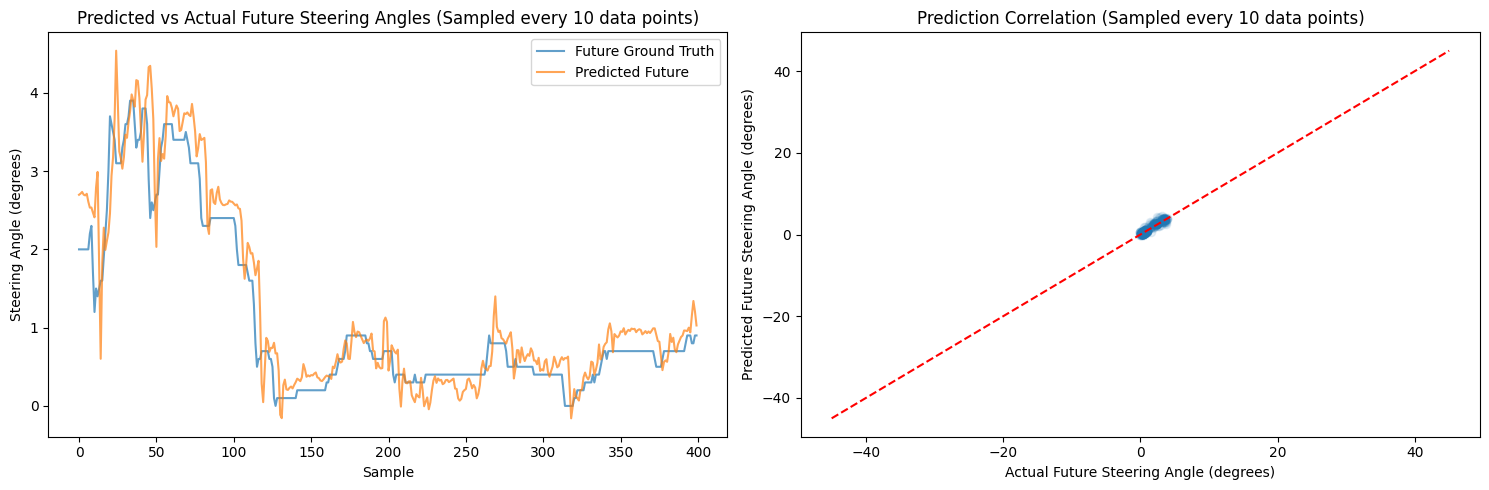


Visualizing some predictions...


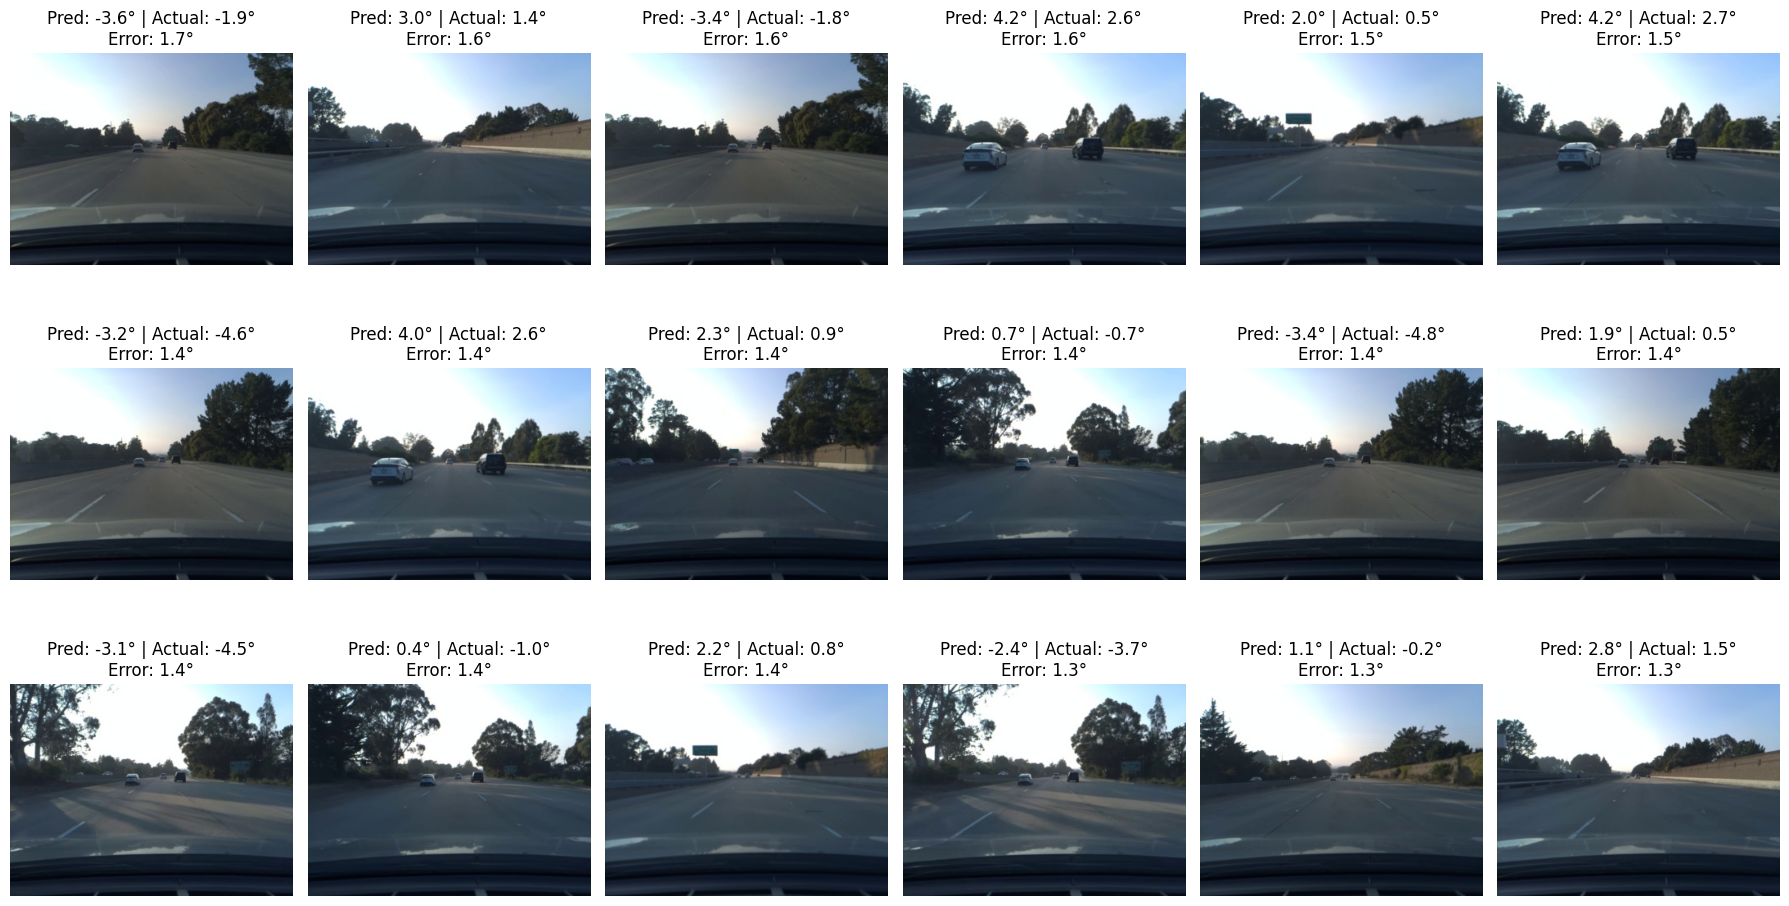

In [9]:
# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

# Now visualize after training
print("\nVisualizing some predictions...")
visualize_most_wrong_predictions(model, test_loader)